### Required imports

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import pyphi # needs nonbinary install
pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.MEASURE = 'AID'
pyphi.config.USE_SMALL_PHI_DIFFERENCE_FOR_CES_DISTANCE = True
pyphi.config.ASSUME_CUTS_CANNOT_CREATE_NEW_CONCEPTS = True
pyphi.config.WELCOME_OFF = True

from temporal_emergence import TPMMaker, CoarseGrainer, PhiCalculator, DataGenerator, Helpers

### Loading data for neurons 143, 168

In [3]:
times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

n_143 = good_neurons_probe1[143]
n_168 = good_neurons_probe1[168]

(371,)
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Users/Marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### Get a nonbinary TPM for neurons 143, 168

In [6]:
neurons = [143,168]
cluster_143_168 = good_neurons_probe1[neurons]
TPM = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,2000)

### Coarse grain it to get the macro

In [7]:
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
macro_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM[0], state_map, num_states_per_elem)

### Do this repeatedly for different samples of the 143,168 data to plot the difference in Phi values.

In [12]:
micro_phis = []
macro_phis = []
for _ in range(10):
    num_transitions = 2000
    TPM,_ = TPMMaker.TPM_from_spiketrains(cluster_143_168,0.005,2,2,num_transitions)
    #np.savetxt("TPMs/micro_example_143_168.csv", TPM)
    micro_phis.append(PhiCalculator.get_micro_average_phi(TPM, verbose=False))
    macro_phis.append(PhiCalculator.get_macro_average_phi(TPM, verbose=False))
print(micro_phis, macro_phis)

                                                                [0.0046673125, 0.0025306874999999973, 0.005074750000000002, 0.006474000000000004, 0.005469312499999997, 0.006858500000000008, 0.0046015625, 0.006047750000000003, 0.005919000000000001, 0.005364375000000003] [0.0032237499999999975, 0.0021702499999999986, 0.0008585000000000051, 0.0, 0.0, 0.0007479999999999917, 0.0, 0.00039150000000000296, 0.0, 0.0007169999999999954]


([<matplotlib.axis.XTick at 0x1294c3e48>,
 <a list of 2 Text xticklabel objects>)

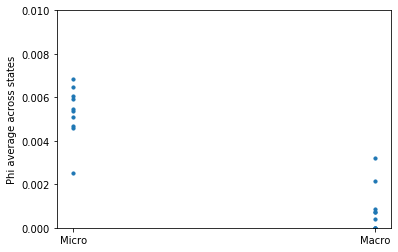

In [13]:
plt.scatter([1 for _ in range(10)] + [2 for _ in range(10)],[micro_phis,macro_phis],s=10)
plt.ylim([0,0.01])
plt.ylabel("Phi average across states")
plt.xticks([1,2],["Micro", "Macro"])

In [3]:

"""
So Nao wants to test what happens in the theoretical case when we get the TPM with data that doesn't 'line up' with the actual step-size of the system. 

So we need a TPM that exhibits emergence and can then generate data for us from which we read back.
"""

# First the original theoretical TPM. This governs the behaviour of the system over timesteps of size 2.
# The problem with this is that it can't actually generate data because it's so deterministic for the 33 state.
micro_TPM = np.array([
    # 00, 10, 20, 30, 01, 11, 21, 31, 02, 12, 22, 32, 03, 13, 23, 33
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #00
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #10
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #20
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #30
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #01
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #11
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #21
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #31
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #02
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #12
    [1/9, 1/9,1/9,0,  1/9,1/9,1/9,0,  1/9,1/9,1/9,0,  0,  0,  0,  0], #22
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1/3,1/3,1/3,0], #32
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #03
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #13
    [ 0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  1/3,0,  0,  0,  0], #23
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1], #33

])

# So let's inject some noise to the TPM, small enough to keep the emergence property, but large enough to give us some
# nonstationary data. 

# NOISE PARAMETER, percent noise
pn = 0.1
l = micro_TPM.shape[0]
def noise(x,pn,l):
    return (1-pn) * x + pn / l
    
micro_TPM_noised = np.array([noise(xi,pn,l) for xi in micro_TPM])

<Figure size 432x288 with 0 Axes>

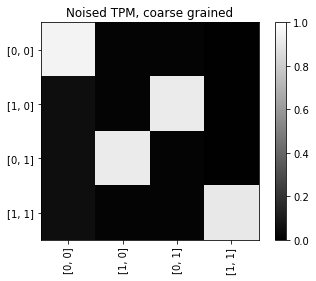

<Figure size 432x288 with 0 Axes>

In [34]:

num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
coarse_grained_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(micro_TPM_noised, state_map, num_states_per_elem)
states = Helpers.get_nary_states(2,2)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(coarse_grained_TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Noised TPM, coarse grained")
plt.colorbar()
plt.figure()


In [4]:
# Now let's generate some data using the noised TPM. 
bitlen = 10**5
base = 4

datagen = DataGenerator(micro_TPM_noised, base)
timeseries = datagen.generate_timeseries(bitlen)


In [12]:
# Now let's get a TPM back and coarse grain it
TPM, _ = TPMMaker.get_TPM_nonbinary(timeseries, 2, 2, 4000)

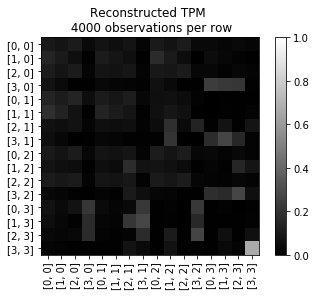

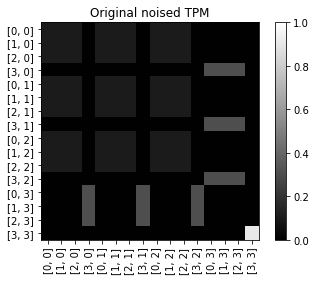

In [30]:
"""plt.imshow(TPM,cmap='gray',extent=None)
plt.title("Reconstructed TPM \n 4000 observations per row")
plt.figure()
plt.title("Original noised TPM")
plt.imshow(micro_TPM_noised,cmap='gray',extent=None)
"""

states = Helpers.get_nary_states(2,4)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Reconstructed TPM \n 4000 observations per row")
plt.colorbar()
plt.figure()
states = [str(state) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(micro_TPM_noised,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Original noised TPM")
plt.colorbar()

<Figure size 432x288 with 0 Axes>

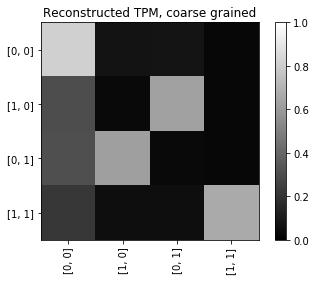

<Figure size 432x288 with 0 Axes>

In [36]:
# Let's also show the coarse grained reconstructed TPM
num_states_per_elem = [2,2]
state_map = {0: [0,1,2, 4,5,6, 8,9,10], 1: [3,7,11], 2: [12,13,14], 3:[15]}
coarse_grained_TPM = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM, state_map, num_states_per_elem)
states = Helpers.get_nary_states(2,2)
states = [str(list(reversed(state))) for state in states]
plt.yticks(range(len(states)),states)
plt.xticks(range(len(states)),states)
plt.xticks(rotation=90)
plt.imshow(coarse_grained_TPM,cmap='gray',extent=None, vmin=0, vmax=1)
plt.title("Reconstructed TPM, coarse grained")
plt.colorbar()
plt.figure()


In [10]:
micro_phi_recons = PhiCalculator.get_micro_average_phi(TPM, verbose=False)
macro_phi_recons = PhiCalculator.get_macro_average_phi(TPM, verbose=False)

print("\n")
print("MACRO PHI, RECONSTRUCTED: ", macro_phi_recons)
print("MICRO PHI, RECONSTRUCTED: ", micro_phi_recons)

micro_phi_actual = PhiCalculator.get_micro_average_phi(micro_TPM_noised, verbose=False)
macro_phi_actual = PhiCalculator.get_macro_average_phi(micro_TPM_noised, verbose=False)

print("\n")
print("MACRO PHI, ACTUAL: ", macro_phi_actual)
print("MICRO PHI, ACTUAL: " ,micro_phi_actual)


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

MACRO PHI, RECONSTRUCTED:  1.0233415
MICRO PHI, RECONSTRUCTED:  0.7034576875
                                                                

MACRO PHI, ACTUAL:  1.7187039999999998
MICRO PHI, ACTUAL:  1.0575045
